In [45]:
# Import the necessary packages and data
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()
path = os.path.expanduser('../data/interim/Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)

In [46]:
wq_df

,Sampling Location,Sample Date,Sample Time,Weather Condition (Dry or Wet),Top Sample Temperature (ºC),Bottom Sample Temperature (ºC),Site Actual Depth (ft),Top Sample Depth(ft),Bottom Sample Depth (ft),Top Salinity (psu),...,Top Ammonium (mg/L),Top Ortho-Phosphorus (mg/L),Top Total Kjeldhal Nitrogen (mg/L),Top Silica (mg/L),Top Total Suspended Solid (mg/L),Bottom Total Suspended Solid (mg/L),Top Active Chlorophyll 'A' (µg/L),Top Dissolved Organic Carbon (mg/L),Long,Lat
0,BR5,2015-08-17,13:07:00,D,24.68,NaN,13.0,3.0,NaN,25.58,...,0.030,0.124,0.435,2.610,16.0,NaN,8.96,2.39,-73.871333,40.813667
1,NC0,2014-02-26,10:45:00,D,2.51,2.46,15.0,3.0,12.0,21.66,...,0.718,0.049,1.700,1.550,11.0,9.00,29.90,3.08,-73.931556,40.714961
2,J7,2006-07-18,13:45:00,D,26.00,25.74,27.0,4.0,26.0,25.14,...,0.402,0.158,1.934,0.833,45.5,3.75,53.23,5.16,-73.820833,40.645333
3,N7,2011-05-18,11:30:00,W,13.90,13.80,53.0,3.0,51.0,17.40,...,0.317,NaN,0.717,1.715,14.0,10.00,1.40,3.00,-74.053833,40.643833
4,GC4,2013-12-10,NaN,W,NaN,NaN,NaN,NaN,NaN,NaN,...,0.644,0.070,0.990,3.120,9.0,NaN,1.60,4.07,-73.989073,40.678034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30997,E2,2017-05-30,09:10:00,D,15.54,15.34,50.0,3.0,48.0,22.04,...,0.401,NaN,0.639,1.093,22.0,16.00,3.09,3.46,-73.970000,40.735330
30998,K5A,2017-07-11,12:56:00,D,22.68,21.15,20.0,3.0,17.0,23.63,...,0.148,NaN,0.466,0.796,14.0,4.00,16.30,2.59,-74.245830,40.484500
30999,NR1,2017-08-14,10:57:00,D,25.05,23.88,50.0,3.0,65.0,10.94,...,0.298,0.076,0.667,1.509,12.0,102.00,2.86,3.17,-73.958160,40.826330
31000,PB2,2017-09-26,11:50:00,D,23.48,22.77,18.0,3.0,14.0,27.55,...,0.187,0.116,0.538,1.560,5.0,8.00,23.40,3.05,-73.909670,40.628000


In [47]:
row_counts = wq_df.notnull().sum(axis=1)

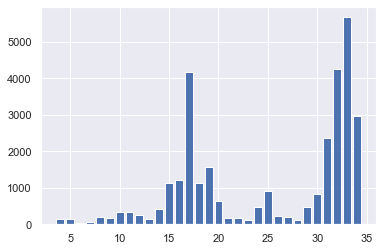

In [48]:
_ = plt.bar(x=row_counts.value_counts().index,
            height=row_counts.value_counts().values)

I want to use only rows with at least 30 columns complete. This is to prevent my data from being overloaded with imputed data.

In [49]:
wq_df['row_sums'] = wq_df.notnull().sum(axis=1)
wq_df[wq_df['row_sums'] < 30]
wq_df = wq_df.drop(columns=['row_sums'])

Next I will fill in blank values

In [50]:
ffill_df = pd.DataFrame()
for site in wq_df['Sampling Location'].unique():
    site_df = wq_df[wq_df['Sampling Location'] == site].sort_values(by='Sample Date')
    site_df = site_df.fillna(method='ffill')
    ffill_df = ffill_df.append(site_df)

In [51]:
final_df = pd.DataFrame()
for site in ffill_df['Sampling Location'].unique():
    site_df = ffill_df[ffill_df['Sampling Location'] == site].sort_values(by='Sample Date')
    site_df = site_df.fillna(method='bfill')
    final_df = final_df.append(site_df)

In [52]:
final_df = final_df.sort_values('Sample Date')
final_df = final_df.reset_index(drop=True)
final_df = final_df.dropna()

In [53]:
# Make dummy columns for dry/wet
final_df = pd.get_dummies(final_df, columns=['Weather Condition (Dry or Wet)'])
final_df = final_df.drop(columns=['Weather Condition (Dry or Wet)_D'])

I noticed something weird with the pH values, so I need to fix them.

In [54]:
final_df.nsmallest(10, 'Top PH')['Top PH']

29379    0.33
5807     6.03
5784     6.32
6170     6.44
8708     6.45
3516     6.49
3604     6.49
3597     6.54
3602     6.54
3506     6.61
Name: Top PH, dtype: float64

In [55]:
final_df = final_df.drop(index=[29360])

In [56]:
final_df = final_df.reset_index(drop=True)

Different parameters will serve different purposes in my analysis. Some measurements have standard limits that must not be exceeded. The rest of the columns will be potential indicators of poor water quality. I have outlined each column's limit/indicator status below:

- Water Temperature = Indicator

- Salinity = Indicator

- Conductivity = Indicator

- Dissolved Oxygen = 3.0 mg/L

- Light Transparency = Indicator

- Sigma-T = Indicator

- Secchi Depth = Indicator

- pH = 6.0 - 9.5

- Fecal Coliform = 2000 cells/100mL

- Enterococcus = 104 cells/100mL

- Ammonia = 2.0 mg/L

- Ortho-phosphate = 0.20 mg/L

- Kjeldahl Nitrogen = 10.0 mg/L

- Silica = Indicator

- Total Suspended Solids = Indicator

- Chlorophyll a = 30

- Dissolved Organic Carbon = Indicator


In [57]:
# Make functions to 
def check_do(measure):
    '''Function checks  Dissolved Oxygen 
       concentration against established
       standards and returns 1 if test 
       fails (ie below 3.0).'''
    if measure < 3.0:
        return 1
    else:
        return 0
    
def check_pH(measure):
    '''Function checks pH levels
       against established standards.
       Returns 1 if test fails (ie less
       than 6.5 or greater than 9.5)'''
    if measure > 9.5 or measure < 6.5:
        return 1
    else:
        return 0
    
def check_fecal(measure):
    '''Function checks Fecal Coliform
       concentration agains established
       standards. Returns 1 if test
       fails (ie above 2000)'''
    if measure > 2000:
        return 1
    else:
        return 0
    
def check_enter(measure):
    '''Function checks Enterococci 
       concentration against established
       standards. Returns 1 if test fails
       (ie above 104)'''
    if measure > 104:
        return 1
    else:
        return 0
    
def check_nitrate(measure):
    '''Function checks Nitrate
       concentration against established
       standards. Returns 1 if test fails
       (ie above 10)'''
    if measure > 10:
        return 1
    else:
        return 0

def check_ammonia(measure):
    '''Function checks Ammonia
       concentration against established
       standards. Returns 1 if test fails
       (ie above 2)'''
    if measure > 2:
        return 1
    else:
        return 0
    
def check_phosphate(measure):
    '''Function checks Phosphate
       concentration against established
       standards. Returns 1 if test fails
       (ie above 0.20)'''
    if measure > 0.20:
        return 1
    else:
        return 0
    
def check_chloro(measure):
    '''Function checks Chlorophyll A
       concentration against established
       standards. Returns 1 if test fails
       (ie above 30)'''
    if measure > 30:
        return 1
    else:
        return 0
    
# Make a dictionary of each parameter with limits and assign its check function   
check_funcs = {'Top Ammonium (mg/L)':check_ammonia,
               'Top Active Chlorophyll \'A\' (µg/L)':check_chloro,
               'CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)':check_do,
               'Top Enterococci Bacteria (Cells/100mL)':check_enter,
               'Top Fecal Coliform Bacteria (Cells/100mL)':check_fecal,
               'Top Total Kjeldhal Nitrogen (mg/L)':check_nitrate,
               'Top PH':check_pH,
               'Top Ortho-Phosphorus (mg/L)':check_phosphate
              }


In [58]:
# Create columns that signify whether a measurement is outside limits
fail_col = []
for col, func in check_funcs.items():
    new_col = col + ' Failure'
    fail_col.append(new_col)
    final_df[new_col] = final_df[col].apply(func)


In [59]:
final_df.loc[:, fail_col].sum()

Top Ammonium (mg/L) Failure                                                             147
Top Active Chlorophyll 'A' (µg/L) Failure                                              3628
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure    1764
Top Enterococci Bacteria (Cells/100mL) Failure                                         2186
Top Fecal Coliform Bacteria (Cells/100mL) Failure                                      1291
Top Total Kjeldhal Nitrogen (mg/L) Failure                                               11
Top PH Failure                                                                            7
Top Ortho-Phosphorus (mg/L) Failure                                                    1814
dtype: int64

# Correlations
Since a lot of my data have varying scales, I am using Spearman's Correlation rather than Pearson's.

In [60]:
corr_df = final_df.corr('spearman')[['Top Active Chlorophyll \'A\' (µg/L)',
                                     'Top Enterococci Bacteria (Cells/100mL)',
                                     'Top Ortho-Phosphorus (mg/L)']]
corr_df

,Top Active Chlorophyll 'A' (µg/L),Top Enterococci Bacteria (Cells/100mL),Top Ortho-Phosphorus (mg/L)
Top Sample Temperature (ºC),0.242572,-0.146180,0.263788
Bottom Sample Temperature (ºC),0.215046,-0.120332,0.296936
Site Actual Depth (ft),-0.286291,-0.079208,-0.136774
Top Sample Depth(ft),-0.035960,-0.033062,0.087853
Bottom Sample Depth (ft),-0.289944,-0.086161,-0.126554
Top Salinity (psu),0.272376,-0.405988,0.048155
Bottom Salinity (psu),0.207953,-0.394705,-0.084309
Top Conductivity (S/m),0.292472,-0.362106,0.225108
Bottom Conductivity (S/m),0.248971,-0.334763,0.166194
"CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)",0.131423,-0.108335,-0.255795


# Strong Correlations
## Chlorophyll A
- Top pH
- Top Silica

## Enterococci
- Top Salinity
- Bottom Salinity
- Top Conductivity
- Bottom Conductivity 
- Top Sigma-T
- Fecal Coliform
- Top Silica
- Weather Condition
- Fecal Coliform Failure

## Ortho-phosphorus
- Top pH
- Ammonium
- Total Kjeldhal Nitrogen
- Top Silica

# Chlorophyll A

In [61]:
chloro_corr_df = final_df.corr('spearman')['Top Active Chlorophyll \'A\' (µg/L)']

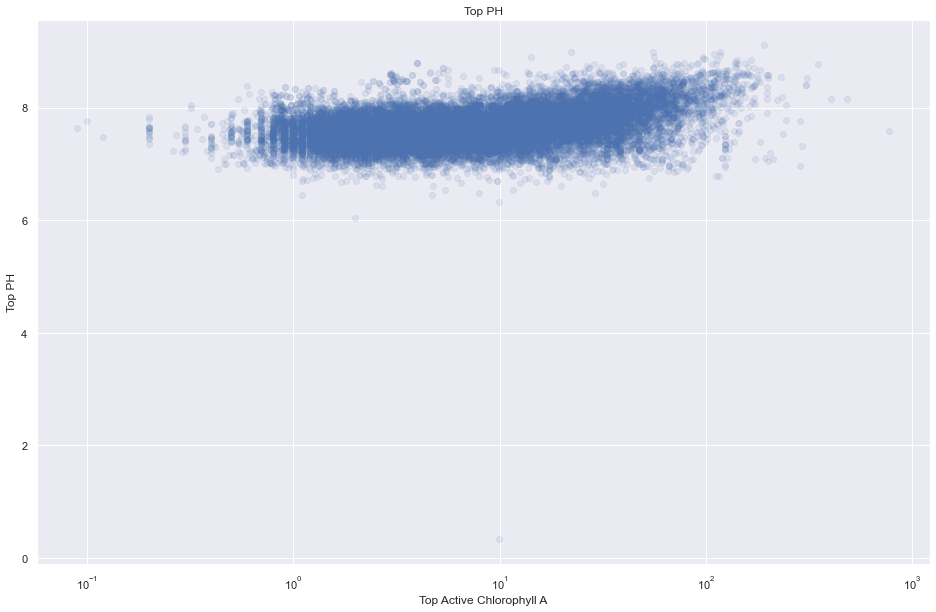

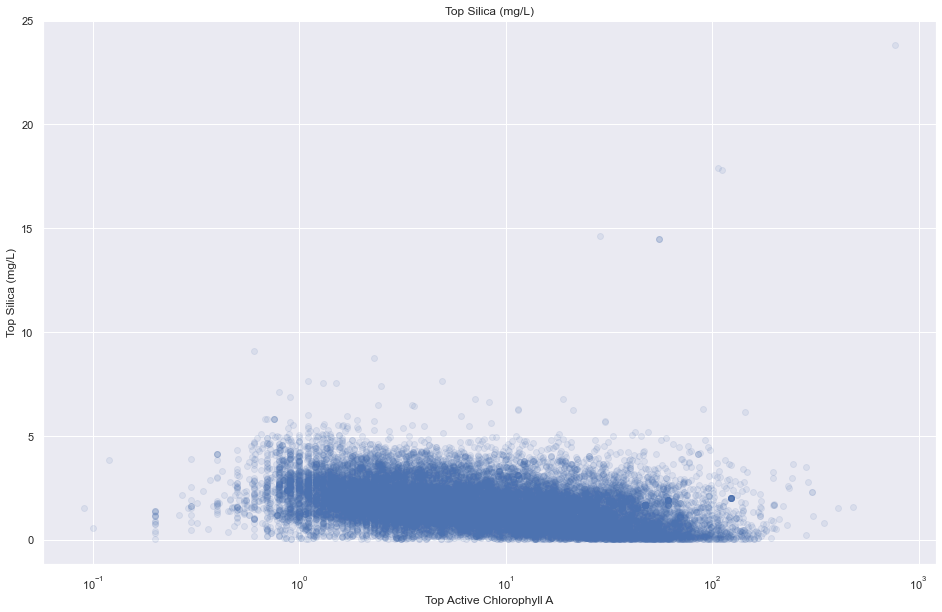

In [62]:
chloro_corr_col = chloro_corr_df[(chloro_corr_df.abs() > 0.3)].index
chloro_corr_col = chloro_corr_col.drop(labels=['Top Active Chlorophyll \'A\' (µg/L)', 
                                               'Top Active Chlorophyll \'A\' (µg/L) Failure'])

#sub = 211
for col in chloro_corr_col:
#    _ = plt.subplot(sub)
    _ = plt.figure(figsize=(16,10))

    _ = plt.scatter(x=final_df['Top Active Chlorophyll \'A\' (µg/L)'],
                    y=final_df[col], alpha=0.1)
    _ = plt.xlabel('Top Active Chlorophyll A')
    _ = plt.ylabel(col)
    _ = plt.xscale('log')
    _ = plt.title(col)
#    sub += 1
        
    _ = plt.show()

# Enterococci

In [63]:
ent_corr_df = final_df.corr('spearman')['Top Enterococci Bacteria (Cells/100mL)']
ent_corr_col = ent_corr_df[(ent_corr_df.abs() > 0.3)].index
ent_corr_col = ent_corr_col.drop(labels=['Top Enterococci Bacteria (Cells/100mL)', 
                                         'Top Enterococci Bacteria (Cells/100mL) Failure'])

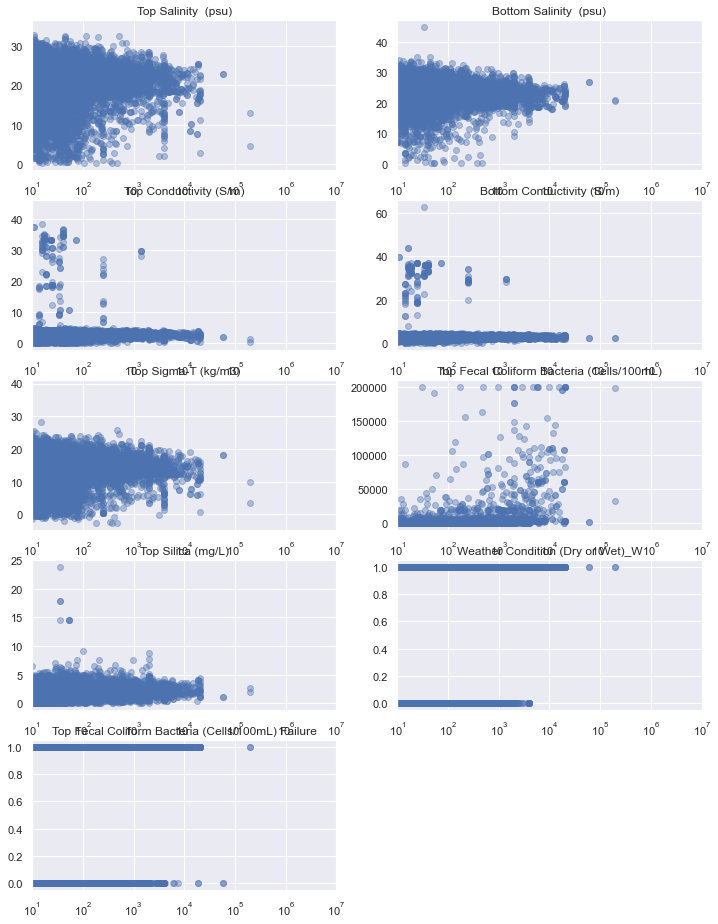

In [64]:
sub = 521
_ = plt.figure(figsize=(12,16))
for col in ent_corr_col:
    _ = plt.subplot(sub)
    _ = plt.scatter(x=final_df['Top Enterococci Bacteria (Cells/100mL)'],
                    y=final_df[col], alpha=0.4)
    _ = plt.xscale('log')
    _ = plt.xlim((10e0, 10e6))
    _ = plt.title(col)
    sub += 1
        
_ = plt.show()


# Ortho-Phosphorus

In [65]:
pho_corr_df = final_df.corr('spearman')['Top Ortho-Phosphorus (mg/L)']
pho_corr_col = pho_corr_df[(pho_corr_df.abs() > 0.3)].index
pho_corr_col = pho_corr_col.drop(labels=['Top Ortho-Phosphorus (mg/L)', 
                                         'Top Ortho-Phosphorus (mg/L) Failure'
                                        ]
                                )                

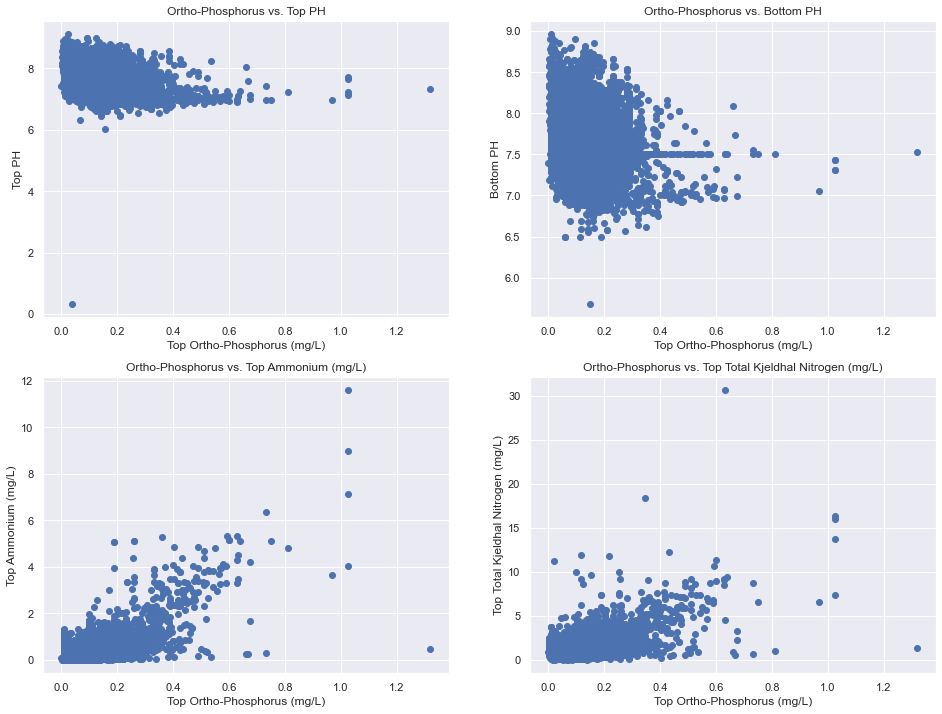

In [66]:
sub = 221
_ = plt.figure(figsize=(16,12))
for col in pho_corr_col:
    if np.dtype(final_df[col]) != object:
        _ = plt.subplot(sub)
        _ = plt.scatter(x=final_df['Top Ortho-Phosphorus (mg/L)'],
                    y=final_df[col])
        _ = plt.title('Ortho-Phosphorus vs. ' + col)
        _ = plt.xlabel('Top Ortho-Phosphorus (mg/L)')
        _ = plt.ylabel(col)
        sub += 1
_ = plt.show()

Taking a look at the totals for each Failure column, the most common pollutant is Chlorophyll A by a followed by Enterococci and Ortho-Phosphorus. I'm going to investigate these three parameters in greater depth.

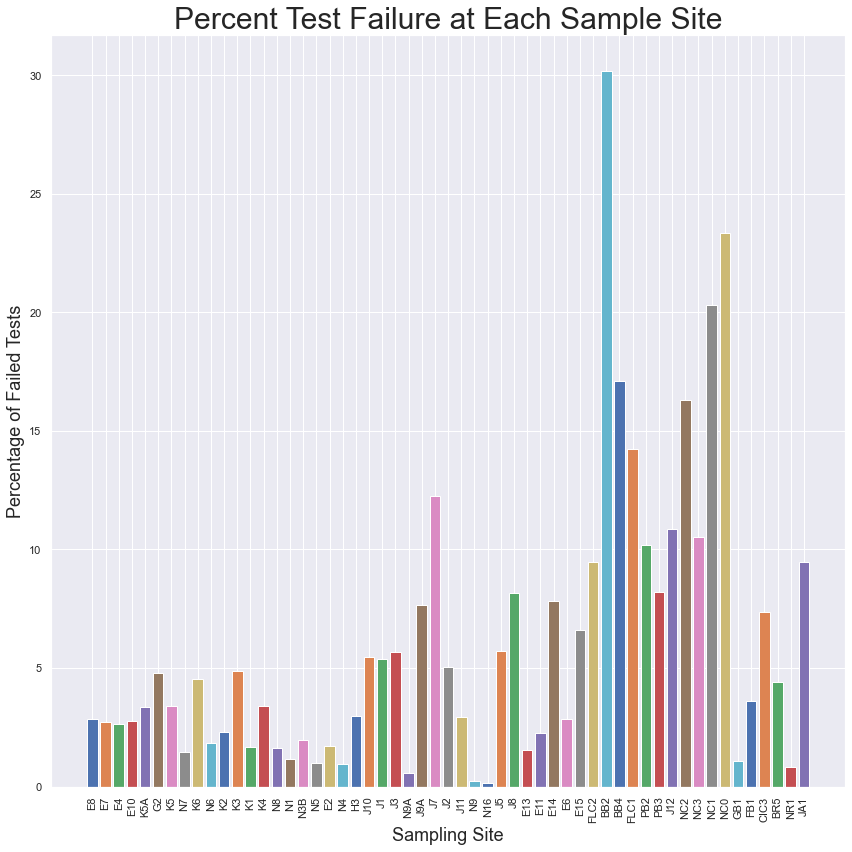

In [67]:
_ = plt.figure(figsize=(12, 12))

for location in final_df['Sampling Location'].unique():
    num = final_df[final_df['Sampling Location'] == location].loc[:, fail_col].sum().sum()
    den = final_df[final_df['Sampling Location'] == location].shape[0]
    ht = num / den / 8 * 100
    _ = plt.bar(x = location, 
            height = ht)

_ = plt.title('Percent Test Failure at Each Sample Site',
             fontsize=30)
_ = plt.xlabel('Sampling Site', fontsize=18)
_ = plt.ylabel('Percentage of Failed Tests', fontsize=18)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

I want to see if there are significant differences between samples that fail to meet EPA limits.

- The null hypothesis is that there is no significant difference between the mean values for samples that exceed limits and those that don't.
- The alternate hypothesis is that there is a significant difference between the means of both.

My original $\alpha$ value is 0.05, but since I am testing 39 columns simultaneously, I need to perform a Bonferroni correction on my $\alpha$ by dividing 0.05 by 39. After doing so, my new $\alpha$ = 0.00128.

I will be performing this for Top Enterococci Bacteria, Top Active Chlorophyll A, and Top Ortho-Phosphate.

# Compare failures to non failed starting with Enterococci

In [68]:
failed_e = final_df[final_df['Top Enterococci Bacteria (Cells/100mL) Failure'] == 1]
passed_e = final_df[final_df['Top Enterococci Bacteria (Cells/100mL) Failure'] == 0]

failed_e = failed_e.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])
passed_e = passed_e.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])

In [69]:
from statsmodels.stats import weightstats

h_o = zip(failed_e.columns, weightstats.ztest(passed_e, failed_e)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
for i in list(h_o):
    if sig(i[1], 0.00128) == 'Significant':
        print(i[0])

Top Sample Temperature (ºC)
Site Actual Depth (ft)
Top Sample Depth(ft)
Bottom Sample Depth (ft)
Top Salinity  (psu)
Bottom Salinity  (psu)
Top Conductivity (S/m)
Bottom Conductivity (S/m)
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)
CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)
Top Sigma-T (kg/m3)
Bottom Sigma-T (kg/m3)
Secchi Depth (ft)
Top PH
Bottom PH
Top Fecal Coliform Bacteria (Cells/100mL)
Top Enterococci Bacteria (Cells/100mL)
Top Ammonium (mg/L)
Top Ortho-Phosphorus (mg/L)
Top Total Kjeldhal Nitrogen (mg/L)
Top Silica (mg/L)
Top Dissolved Organic Carbon (mg/L)
Weather Condition (Dry or Wet)_W
Top Ammonium (mg/L) Failure
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure
Top Enterococci Bacteria (Cells/100mL) Failure
Top Fecal Coliform Bacteria (Cells/100mL) Failure
Top PH Failure
Top Ortho-Phosphorus (mg/L) Failure


/Users/drewadamski/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:746: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff


# Chlorophyll A Differences

In [70]:
failed_c = final_df[final_df['Top Active Chlorophyll \'A\' (µg/L) Failure'] == 1]
passed_c = final_df[final_df['Top Active Chlorophyll \'A\' (µg/L) Failure'] == 0]

failed_c = failed_c.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])
passed_c = passed_c.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])

In [71]:
from statsmodels.stats import weightstats

h_o = zip(failed_c.columns, weightstats.ztest(passed_c, failed_c)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
for i in list(h_o):
    if sig(i[1], 0.00128) == 'Significant':
        print(i[0])

Top Sample Temperature (ºC)
Bottom Sample Temperature (ºC)
Site Actual Depth (ft)
Bottom Sample Depth (ft)
Top Salinity  (psu)
Bottom Salinity  (psu)
Top Conductivity (S/m)
Bottom Conductivity (S/m)
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)
Light Trans (% transparency) Top Sample
Light Trans (% transparency) Bottom Sample
Top Sigma-T (kg/m3)
Bottom Sigma-T (kg/m3)
Secchi Depth (ft)
Top PH
Bottom PH
Top Fecal Coliform Bacteria (Cells/100mL)
Top Ammonium (mg/L)
Top Ortho-Phosphorus (mg/L)
Top Total Kjeldhal Nitrogen (mg/L)
Top Silica (mg/L)
Top Total Suspended Solid (mg/L)
Bottom Total Suspended Solid (mg/L)
Top Active Chlorophyll 'A' (µg/L)
Top Dissolved Organic Carbon (mg/L)
Weather Condition (Dry or Wet)_W
Top Ammonium (mg/L) Failure
Top Active Chlorophyll 'A' (µg/L) Failure
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure
Top Fecal Coliform Bacteria (Cells/100mL) Failure
Top Ortho-Phosphorus (mg/L) Failure


/Users/drewadamski/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:746: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff


# Ortho-Phosphate Differences

In [72]:
failed_p = final_df[final_df['Top Enterococci Bacteria (Cells/100mL) Failure'] == 1]
passed_p = final_df[final_df['Top Enterococci Bacteria (Cells/100mL) Failure'] == 0]

failed_p = failed_p.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])
passed_p = passed_p.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])

In [73]:
from statsmodels.stats import weightstats

h_o = zip(failed_p.columns, weightstats.ztest(passed_p, failed_p)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
for i in list(h_o):
    if sig(i[1], 0.00128) == 'Significant':
        print(i[0])

Top Sample Temperature (ºC)
Site Actual Depth (ft)
Top Sample Depth(ft)
Bottom Sample Depth (ft)
Top Salinity  (psu)
Bottom Salinity  (psu)
Top Conductivity (S/m)
Bottom Conductivity (S/m)
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)
CTD (conductivity, temperature, depth profiler) Bottom Dissolved Oxygen (mg/L)
Top Sigma-T (kg/m3)
Bottom Sigma-T (kg/m3)
Secchi Depth (ft)
Top PH
Bottom PH
Top Fecal Coliform Bacteria (Cells/100mL)
Top Enterococci Bacteria (Cells/100mL)
Top Ammonium (mg/L)
Top Ortho-Phosphorus (mg/L)
Top Total Kjeldhal Nitrogen (mg/L)
Top Silica (mg/L)
Top Dissolved Organic Carbon (mg/L)
Weather Condition (Dry or Wet)_W
Top Ammonium (mg/L) Failure
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure
Top Enterococci Bacteria (Cells/100mL) Failure
Top Fecal Coliform Bacteria (Cells/100mL) Failure
Top PH Failure
Top Ortho-Phosphorus (mg/L) Failure


/Users/drewadamski/opt/anaconda3/lib/python3.8/site-packages/statsmodels/stats/weightstats.py:746: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff


I am going to look at monthly failures

In [77]:
final_df['Month'] = final_df['Sample Date'].map(lambda x: x.month)
pivot = final_df.pivot_table(
    values=[
        'Top Enterococci Bacteria (Cells/100mL) Failure',
        'Top Ortho-Phosphorus (mg/L) Failure',
        'Top Active Chlorophyll \'A\' (µg/L) Failure'
    ],
    index='Month', aggfunc='sum')


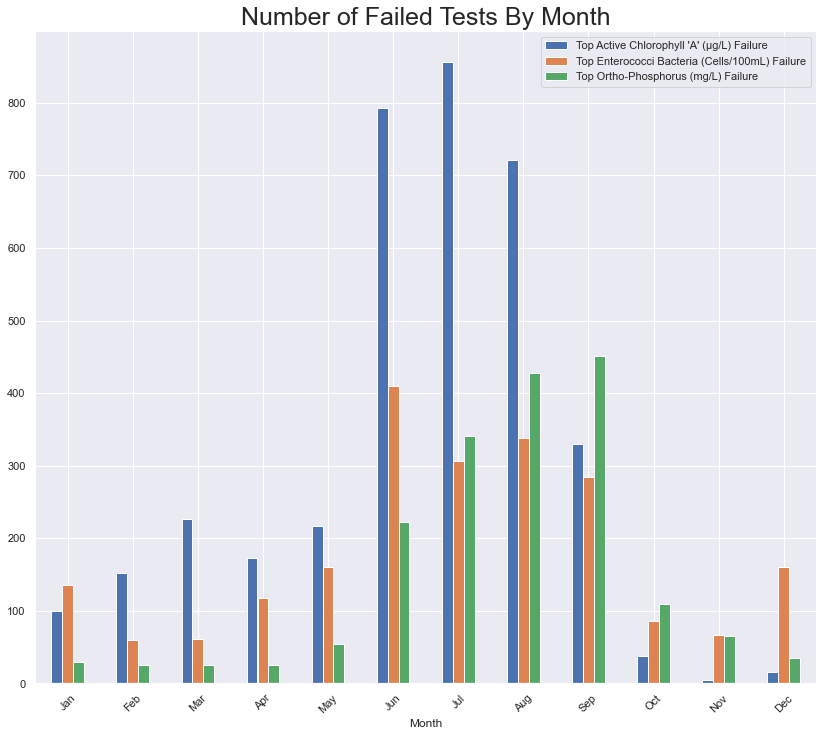

In [78]:
_ = pivot.plot(kind='bar', figsize=(14, 12))
_ = plt.xticks(np.arange(0, 12), 
           labels=['Jan', 'Feb', 'Mar', 'Apr',
                   'May', 'Jun', 'Jul', 'Aug',
                   'Sep', 'Oct', 'Nov', 'Dec'],
           rotation=45)
_ = plt.title('Number of Failed Tests By Month', fontsize=25)
_ = plt.show()

There are clearly temportal trends in failed tests. 

Now that I have a sense of my data, I can begin performing analysis.

In [79]:
# outpath = os.path.expanduser('~/Projects/capstone-two/data/processed/Final_Clean_Harbor_Water_Quality.csv')
# final_df.to_csv(outpath)